## Diabetes Prediction

---

- This is a beginner friendly notebook to build a simple Logistic regression for diabetes prediction. The data is from Kaggle. Please head there and get the data so that you can follow along.


- The notebook is divided into 2 section data science project i.e. *exploratory data analysis* and *modeling*.


- I have also added comments on the analysis report providing what is done, why it is important and the observations from the analysis. Enjoy learning!

In [2]:
# Required libraries
import pandas as pd
import numpy as np
import scipy
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy.stats import zscore
import scipy.stats as stats

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from statsmodels.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tabulate import tabulate

# notebook display settings
plt.style.use('ggplot')
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_columns=None
pd.options.display.max_rows=None

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# read the dataset
df = pd.read_csv("../diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.60,0.63,50,1
1,1,85,66,29,0,26.60,0.35,31,0
2,8,183,64,0,0,23.30,0.67,32,1
3,1,89,66,23,94,28.10,0.17,21,0
4,0,137,40,35,168,43.10,2.29,33,1


In [4]:
df.shape

(768, 9)

### Helper Functions

These functions will help in performing a deeper exploration of the data in a convenient way.

In [5]:
 class ExploreData():
        
    def __init__(self, data):
        
        self.data = data
        
    def get_statistical_summary(self):
        
        """
        Get statistical summary of variables the data
        """
        
        print("Statistical summary for all the dataset")
        
        print("=============================================")
        print("Total records: ",self.data.shape[0])
        print("Total variables: ",self.data.shape[1])
        
        # duplicates
        duplicated_df = self.data[self.data.duplicated(keep=False)]     
        num_duplicates = len(duplicated_df)
        percent_duplicates = round(num_duplicates / len(self.data)*100,2)
        print(f"Total duplicate records: {num_duplicates}({percent_duplicates}%)")
        print("=============================================")
        
        
        # missing values and data types
        d_types = pd.DataFrame(self.data.dtypes).reset_index()
        d_types.columns = ['variable', 'dtype']
        
        missing = pd.DataFrame(self.data.isnull().sum().reset_index().values, columns=['variable','missing'])
        missing['%_missing'] = missing['missing']/len(self.data) * 100
        d_types_df = pd.DataFrame(self.data.dtypes).reset_index()
        d_types_df.columns = ['variable', 'dtype']
        missing = d_types_df.merge(missing, on='variable')
        
        # descriptive statistics
        summary_statistics = self.data.describe(include="all").T.reset_index().rename(columns={'index':'variable'})

        # calculate unique values in each column
        unique_values = {col: self.data[col].nunique() for col in summary_statistics['variable'].unique()}
        unique_df = pd.DataFrame.from_dict(unique_values, orient='index', 
                        columns=['num_unique']).reset_index().rename(columns={'index':"variable"})
        
        # median
        median_values = {col: self.data[col].median() for col in summary_statistics['variable'].unique() 
                         if self.data[col].dtype!='object'}
        median_df = pd.DataFrame.from_dict(median_values, orient='index', 
                        columns=['median']).reset_index().rename(columns={'index':"variable"})

        # mode
        modal_values = {}
        for col in summary_statistics['variable'].unique():
            modes = self.data[col].mode()
            if not modes.empty:
                modal_values[col] = modes.iat[0]
            else:
                modal_values[col] = None
                
        modal_df = pd.DataFrame.from_dict(modal_values, orient='index', 
                        columns=['mode']).reset_index().rename(columns={'index': 'variable'})

        # skewness
        skewness_values = {col: self.data[col].skew() for col in summary_statistics['variable'].unique() 
                           if self.data[col].dtype not in ['object','datetime64[ns]']}
        skewness_df = pd.DataFrame.from_dict(skewness_values, orient='index', 
                        columns=['skewness']).reset_index().rename(columns={'index':"variable"})

        # number of outliers
        outliers_df = pd.DataFrame(columns=["variable","num_outliers"])
        cols = summary_statistics['variable'].unique()
        for col in cols:
            if self.data[col].dtype in ['object','datetime64[ns]']:
                num_outliers=None
            else:
                z_scores = zscore(df[col])
                num_outliers = (abs(z_scores) > 3).sum()
                
            outliers_df = outliers_df.append({'variable': col, 'num_outliers': num_outliers},ignore_index=True)
        
        # check for normality using Shapiro wilk test
        normality_df = pd.DataFrame(columns=["variable","statistic","pValue"])
        for col in df.columns:
            if self.data[col].dtype not in ['object','datetime64[ns]']:
            
                stat, p = stats.shapiro(self.data[col])
                normality_df = normality_df.append({"variable":col,"statistic":stat,"pValue":p}, ignore_index=True)
                
        # if p_value > 0.05, then the distribution is normal
        normality_df['normality'] = np.where(normality_df['pValue']>0.05,True,False)
        normality_df.drop(columns=['statistic','pValue'], inplace=True)
        
        # summary
        summary_statistics = missing.merge(summary_statistics, on='variable')
        summary_statistics = summary_statistics.merge(unique_df, on='variable')
        summary_statistics = summary_statistics.merge(median_df, on='variable',how='left')
        summary_statistics = summary_statistics.merge(modal_df, on='variable',how='left')
        summary_statistics = summary_statistics.merge(skewness_df, on='variable', how='left')
        summary_statistics = summary_statistics.merge(outliers_df, on='variable',how='left')
        summary_statistics = summary_statistics.merge(normality_df, on='variable',how='left')
        
        return summary_statistics
    
    def check_skewness(self, variable):
        
        """Check skewness of a variable
        """

        # calculate skewness
        skewness_coefficient = round(self.data[variable].skew(),4)
        print("Skewness coefficient: ",skewness_coefficient)
        
        plt.figure(1)
        plt.subplot(121), sns.distplot(self.data[variable], bins='auto')
        plt.title(f'Distribution of {variable}', fontdict={"size":10, "color":"blue"})
        plt.subplot(122), self.data[variable].plot.box(figsize=(16,5))
        plt.title(f'Distribution of {variable} using boxplot', fontdict={"size":10, "color":"blue"})
        plt.show()

##  1. Exploratory Data Analysis

In [6]:
# check statistcal summary of all variables of the dataset

explorer = ExploreData(df)
explorer.get_statistical_summary()

Statistical summary for all the dataset
Total records:  768
Total variables:  9
Total duplicate records: 0(0.0%)


,variable,dtype,missing,%_missing,count,mean,std,min,25%,50%,75%,max,num_unique,median,mode,skewness,num_outliers,normality
0,Pregnancies,int64,0,0.00,768.00,3.85,3.37,0.00,1.00,3.00,6.00,17.00,17,3.00,1.00,0.90,4,False
1,Glucose,int64,0,0.00,768.00,120.89,31.97,0.00,99.00,117.00,140.25,199.00,136,117.00,99.00,0.17,5,False
2,BloodPressure,int64,0,0.00,768.00,69.11,19.36,0.00,62.00,72.00,80.00,122.00,47,72.00,70.00,-1.84,35,False
3,SkinThickness,int64,0,0.00,768.00,20.54,15.95,0.00,0.00,23.00,32.00,99.00,51,23.00,0.00,0.11,1,False
4,Insulin,int64,0,0.00,768.00,79.80,115.24,0.00,0.00,30.50,127.25,846.00,186,30.50,0.00,2.27,18,False
5,BMI,float64,0,0.00,768.00,31.99,7.88,0.00,27.30,32.00,36.60,67.10,248,32.00,32.00,-0.43,14,False
6,DiabetesPedigreeFunction,float64,0,0.00,768.00,0.47,0.33,0.08,0.24,0.37,0.63,2.42,517,0.37,0.25,1.92,11,False
7,Age,int64,0,0.00,768.00,33.24,11.76,21.00,24.00,29.00,41.00,81.00,52,29.00,22.00,1.13,5,False
8,Outcome,int64,0,0.00,768.00,0.35,0.48,0.00,0.00,0.00,1.00,1.00,2,0.00,0.00,0.64,0,False


**Note 1:**
    
  - **What?**: This statistical summary functions provides a general summary of the data by giving a detailed statistical summary of each variable in the dataset. This report helps to know the total records, variables and whether there are missing values and duplicates. It goes futher to check the measures of central tendency and dispersion. Finally, it checks skweness, number of outliers and whther the variable is normally distributed or not. It helps in understanding the data we are working with and can inform our further analysis.
  
  
  - **Observations from the data**: From the analysis, we can observe the following:
      - Total of 768 records and 9 variables
      - No missing values and no duplicates.
      - Most variables have high standard deviations which suggests presence of outliers in the data
      - Since there are outliers in the data, the variables exhibit slight levels of skewness and none of them have a normal distribution

Skewness coefficient:  0.9017


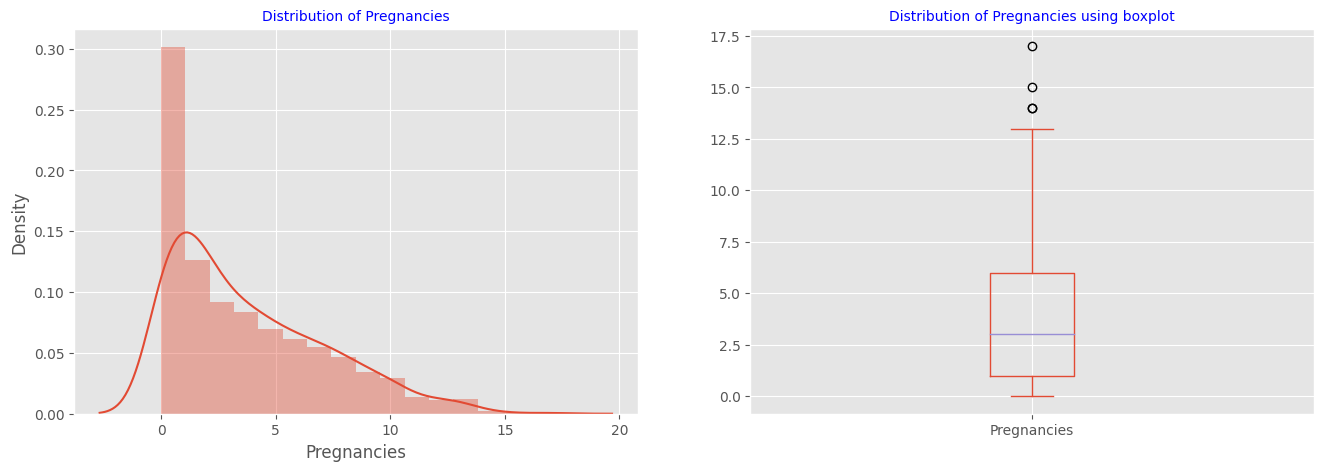

In [7]:
# check skewness of pregnacies
explorer.check_skewness("Pregnancies")

Skewness coefficient:  0.1738


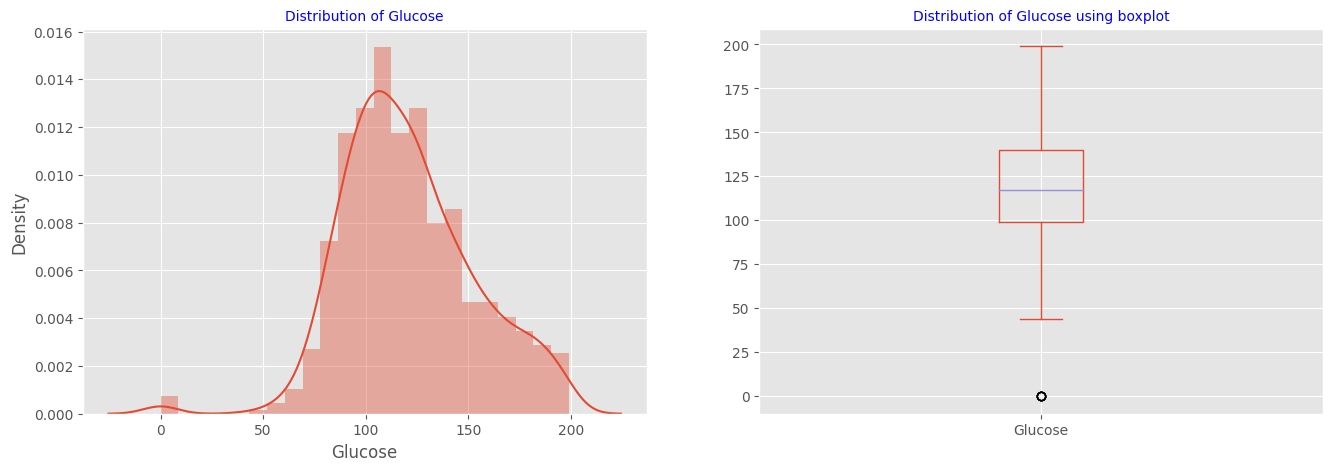

In [8]:
# check skewness of glucose
explorer.check_skewness("Glucose")

Skewness coefficient:  -1.8436


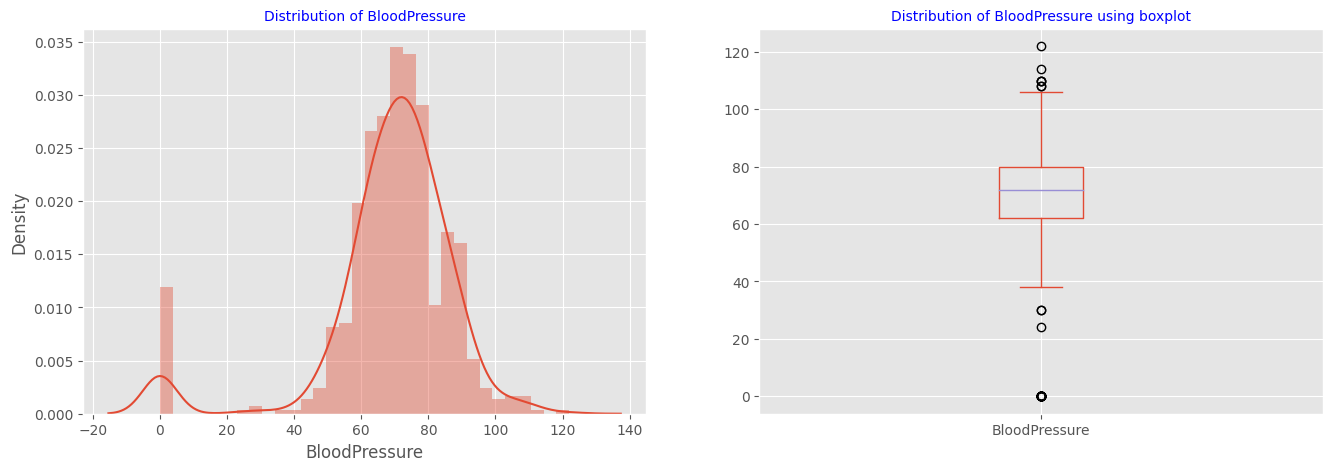

In [9]:
# check skewness of bloodpressure
explorer.check_skewness("BloodPressure")

Skewness coefficient:  0.1094


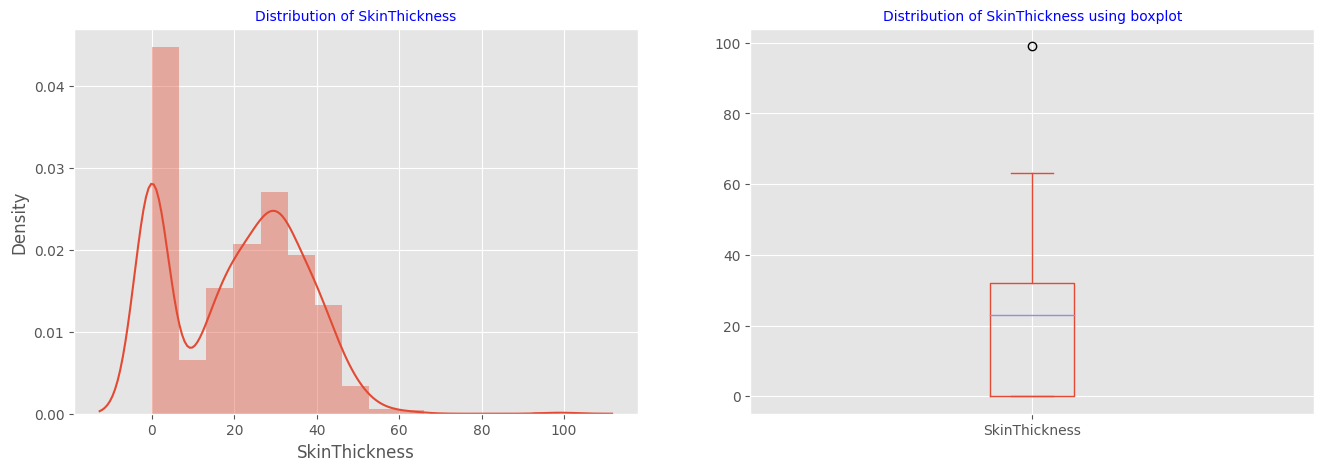

In [10]:
# check skewness of SkinThickness
explorer.check_skewness("SkinThickness")

Skewness coefficient:  2.2723


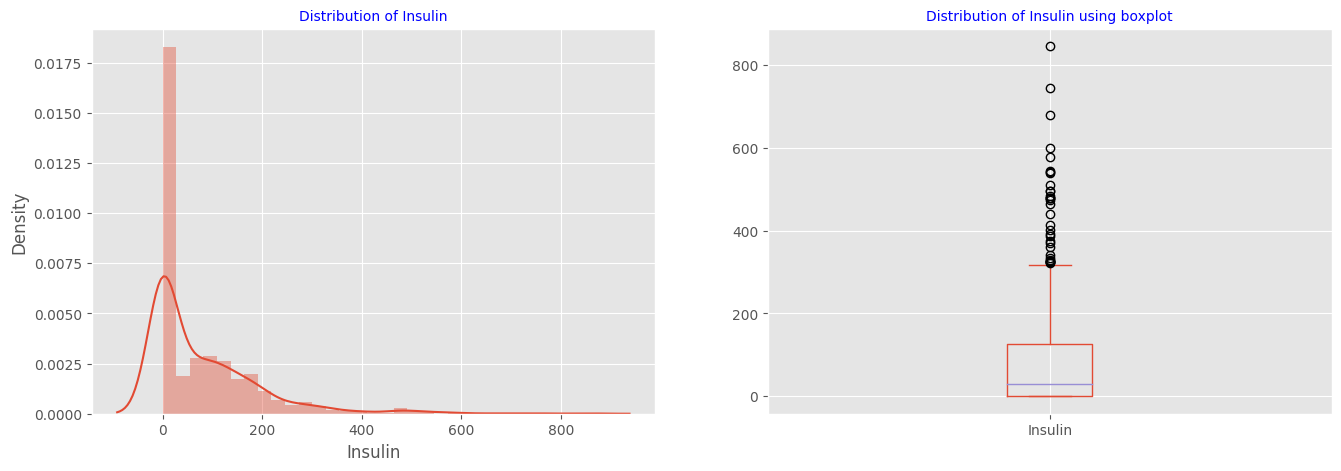

In [11]:
# check skewness of insulin
explorer.check_skewness("Insulin")

Skewness coefficient:  -0.429


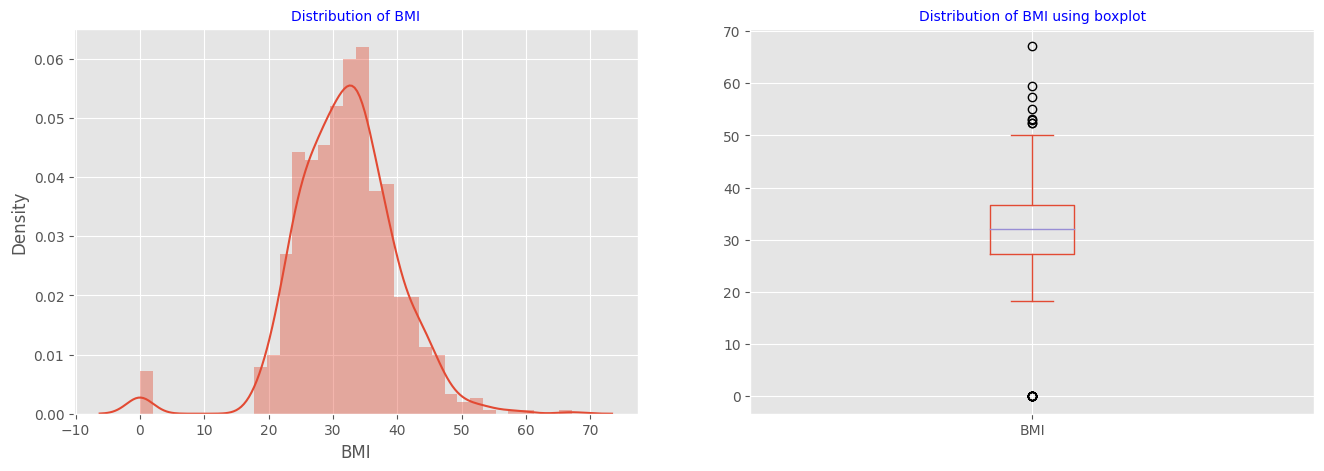

In [12]:
# check skewness of bmi
explorer.check_skewness("BMI")

Skewness coefficient:  1.9199


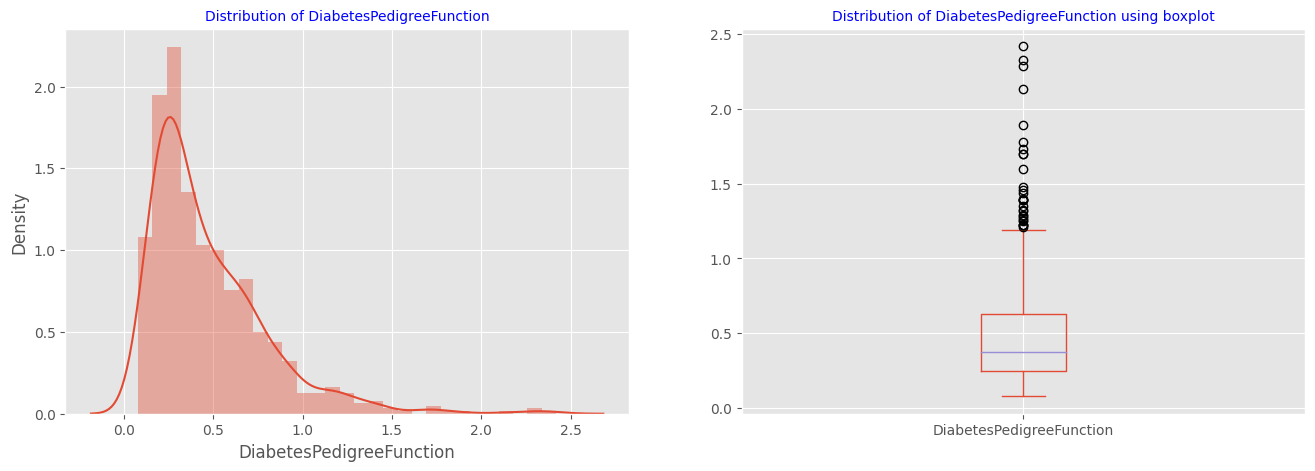

In [13]:
# check skewness of DiabetesPedigreeFunction
explorer.check_skewness("DiabetesPedigreeFunction")

Skewness coefficient:  1.1296


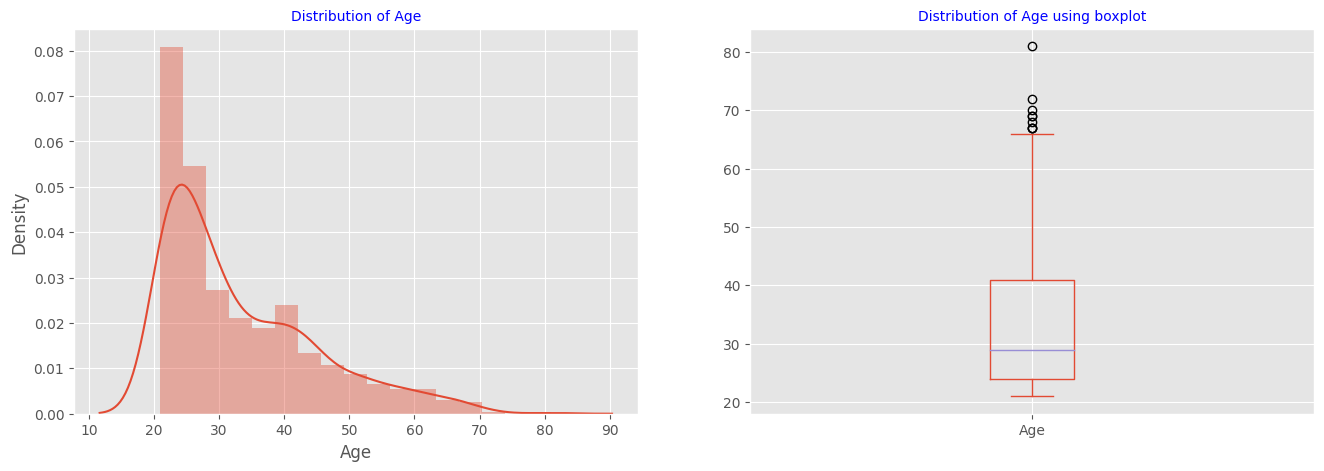

In [14]:
# check skewness of Age
explorer.check_skewness("Age")

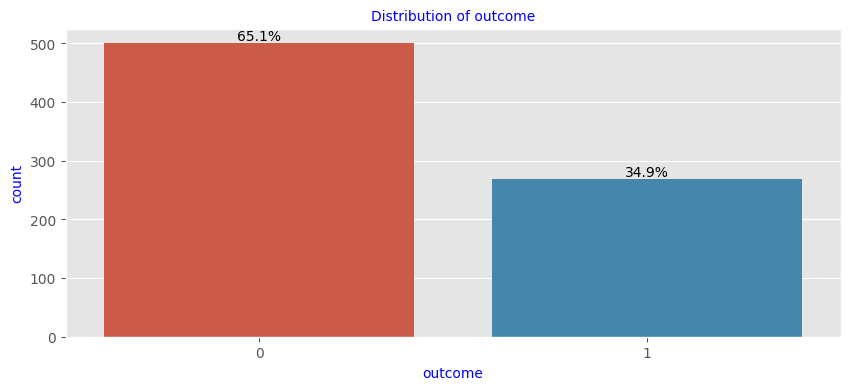

In [15]:
#Plotting the distribution of Outcome
plt.figure(figsize=(10,4))
ax = sns.countplot(x= 'Outcome', data = df)

total = len(df['Outcome'])  # Total outcomes
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)  # Calculate percentage
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')
    
plt.xlabel('outcome',fontdict={"size":10, "color":"blue"})
plt.ylabel('count', fontdict={"size":10, "color":"blue"})
plt.title(f'Distribution of outcome', fontdict={"size":10, "color":"blue"})
plt.show()

## 2. Feature Selection

#### 2.1. Correlations 

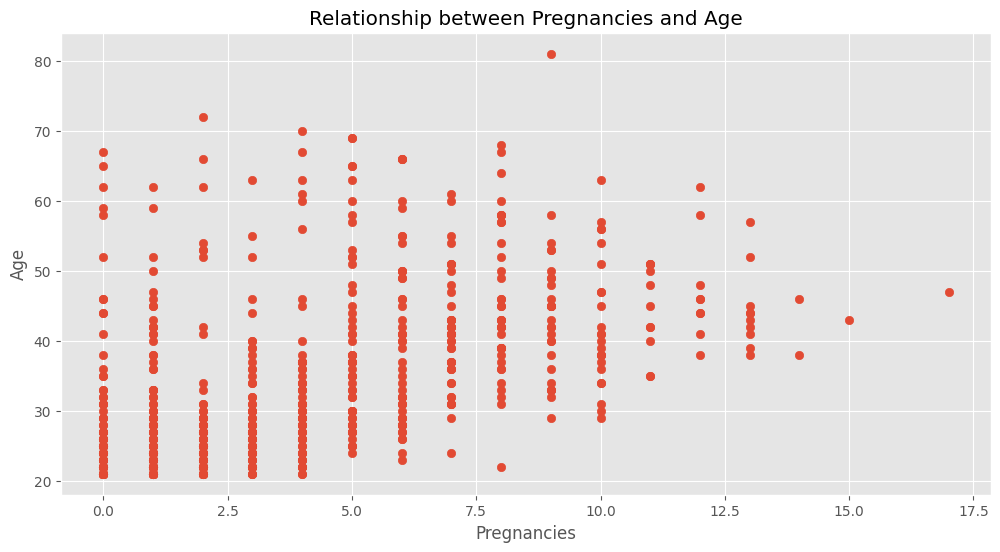

In [16]:
var1 = "Pregnancies"
var2 = "Age"
plt.figure(figsize=(12,6))
plt.scatter(df[var1],df[var2])
plt.title(f'Relationship between {var1} and {var2}')
plt.xlabel('Pregnancies')
plt.ylabel('Age')
# Display the plot
plt.show()

In [17]:
correlation_table = df.corr()
correlation_to_outcome = correlation_table['Outcome']
correlation_to_outcome = pd.DataFrame({'variable':correlation_to_outcome.index,
                                       'correlation_coeff.':correlation_to_outcome.values})
correlation_to_outcome = correlation_to_outcome.sort_values('correlation_coeff.', ascending=False)
correlation_to_outcome

,variable,correlation_coeff.
8,Outcome,1.00
1,Glucose,0.47
5,BMI,0.29
7,Age,0.24
0,Pregnancies,0.22
6,DiabetesPedigreeFunction,0.17
4,Insulin,0.13
3,SkinThickness,0.07
2,BloodPressure,0.07


#### 2.2. Multicollinearity

In [18]:
# Check for multicollinearity using Variance Inflaction Factor

input_variables = df.drop(columns=['Outcome'], axis=1)
target_variable = df['Outcome']

# Add constant term to the variables
input_variables = add_constant(input_variables)

# Calculate variable inflaction factor for each variable
vif = pd.DataFrame()
vif['Variable'] = input_variables.columns
vif['VIF'] = [variance_inflation_factor(input_variables.values,i) for i in range(input_variables.shape[1])]
vif

,Variable,VIF
0,const,35.04
1,Pregnancies,1.43
2,Glucose,1.30
3,BloodPressure,1.18
4,SkinThickness,1.51
5,Insulin,1.43
6,BMI,1.30
7,DiabetesPedigreeFunction,1.07
8,Age,1.59


**Observation**: Typically, a VIF value above 5 is generally considered high, indicating potential multicollinearity. This shows absence of multicollinearity in our data

#### 2.3. Causal Relationships

In [19]:
# checking for causal relationships

# add constant term to the variables
input_variables = add_constant(input_variables)

logistic_regression_model = sm.Logit(target_variable,input_variables)

results = logistic_regression_model.fit()

print(results.summary())

Optimization terminated successfully.
         Current function value: 0.470993
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      759
Method:                           MLE   Df Model:                            8
Date:                Thu, 22 Jun 2023   Pseudo R-squ.:                  0.2718
Time:                        10:27:17   Log-Likelihood:                -361.72
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 9.652e-54
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -8.4047      0.717    -11.728      0.000      -9.809

In [20]:
# get variable, coefficients and p-values only

table_data = []
headers = ['Variable', 'Coefficient', 'AbsoluteCoefficient','P-value']

# Extract coefficients and p-values from the summary
coefficients = results.params
p_values = results.pvalues

for var, coef, abscoef, pval in zip(coefficients.index, coefficients, abs(coefficients), p_values):
    table_data.append([var, round(coef,4), round(abscoef,4), round(pval,4)])

# Print the table
print(tabulate(table_data, headers, tablefmt="fancy_grid"))

╒══════════════════════════╤═══════════════╤═══════════════════════╤═══════════╕
│ Variable                 │   Coefficient │   AbsoluteCoefficient │   P-value │
╞══════════════════════════╪═══════════════╪═══════════════════════╪═══════════╡
│ const                    │       -8.4047 │                8.4047 │    0      │
├──────────────────────────┼───────────────┼───────────────────────┼───────────┤
│ Pregnancies              │        0.1232 │                0.1232 │    0.0001 │
├──────────────────────────┼───────────────┼───────────────────────┼───────────┤
│ Glucose                  │        0.0352 │                0.0352 │    0      │
├──────────────────────────┼───────────────┼───────────────────────┼───────────┤
│ BloodPressure            │       -0.0133 │                0.0133 │    0.0111 │
├──────────────────────────┼───────────────┼───────────────────────┼───────────┤
│ SkinThickness            │        0.0006 │                0.0006 │    0.9285 │
├──────────────────────────┼

**Observation**: Absolute coefficient shows the magnitude of the effect of the independent variable on the dependent variable. The higher the magnitude the more the independent variable potentially affects the dependent variable. 

Also, the p-values shows the statistical significance of the independent variable by providing the probability of rejecting the null hypothesis - the relationship is a random chance (zero coefficient). Therefore p-values less than 0.05 show that the relationships are unlikely to be a random chance. And this implies that such variables potentially has an effect on the dependent variable.

In this case, the *const, Pregnancies, Glucose, BloodPressure, BMI,* and *DiabetesPedigreeFunction* variables have p-values less than 0.05, suggesting that their relationships with the dependent variable are statistically significant.

On the other hand, the *SkinThickness, Insulin,* and *Age* variables have p-values greater than 0.05, indicating that their relationships with the dependent variable may not be statistically significant.

## 3. Machine Learning Model

In [21]:
#Splitting the dataset with all the original features
print(input_variables.shape)
X_train, X_test, y_train, y_test = train_test_split(input_variables, target_variable, test_size=0.33,
                                                    random_state=7)

(768, 9)


### 3.1. Logistic Regression

Reasons for using Logistic Rgeression in this project:
- It is a binary problem. I need to predict 0 or 1 (No diabetes or has diabetes)
- Easy to implement and interpret hence good for simple classification problems
- Logistic regression outputs probabilities of class membership, ranging from 0 to 1. This allows for intuitive interpretation of the model's predictions as probabilities of belonging to a particular class.
- Provides coefficient values for each predictor variable, indicating their impact on the predicted outcome. This can help in understanding the importance of different features in the classification task.

In [52]:
# Fit a Logostic Regression model
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train,y_train)

LogisticRegression()

In [53]:
# Check predictions
lr_predictions = lr_classifier.predict(X_test)
lr_predictions[:10]

array([0, 1, 1, 0, 0, 1, 0, 0, 1, 0])

In [65]:
# MODEL EVALUATION

def get_model_performance_metrics(model, predictions):
    
    # Accuracy score
    accuracy = metrics.accuracy_score(y_test, predictions)

    # Calculate precision
    precision = metrics.precision_score(y_test, predictions)

    # Calculate recall
    recall = metrics.recall_score(y_test, predictions)

    # Calculate F1-score
    f1 = metrics.f1_score(y_test, predictions)

    # Calculate AUC-ROC
    y_pred_prob = model.predict_proba(X_test)[:, 1] #get predicted probabilities
    
    auc_roc = metrics.roc_auc_score(y_test, y_pred_prob)

    # Print the evaluation metrics
    print("Accuracy:", round(accuracy,4))
    print("Precision:", round(precision,4))
    print("Recall:", round(recall,4))
    print("F1-score:", round(f1,4))
    print("AUC-ROC:", round(auc_roc,4))

In [66]:
# model performance
get_model_performance_metrics(lr_classifier,lr_predictions)

Accuracy: 0.7677
Precision: 0.7037
Recall: 0.6196
F1-score: 0.659
AUC-ROC: 0.8266


### 3.2. Hyperparameter Tuning

In [55]:
# Hyperparameter tuning for logistic regression

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
}

grid_search = GridSearchCV(lr_classifier, param_grid, cv=9)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

# Evaluate the accuracy of the best model
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Best model accuracy:", accuracy)
print("Best hyperparameters:", best_params)

Best model accuracy: 0.7834645669291339
Best hyperparameters: {'C': 10, 'penalty': 'l2'}


### 3.3. Model Evaulation

In [68]:
# evalating tuned model
get_model_performance_metrics(best_model,y_pred)

Accuracy: 0.7835
Precision: 0.7342
Recall: 0.6304
F1-score: 0.6784
AUC-ROC: 0.829


*Accuracy:* 0.7835: This indicates that 78.35% of the predictions made by the model are correct.

*Precision:* 0.7342: Precision measures the proportion of true positive predictions out of all positive predictions made by the model. In this case, the model has a precision of 73.42%, indicating that when it predicts a positive class, it is correct 73.42% of the time.

*Recall:* 0.6304: Recall, also known as sensitivity or true positive rate, measures the proportion of true positive predictions out of all actual positive instances in the data. The model has a recall of 63.04%, indicating that it captures 63.04% of the actual positive instances.

*F1-score:* 0.6784: The F1-score is the harmonic mean of precision and recall. It provides a balanced measure of both metrics. This model has an F1-score of 67.84%, indicating a trade-off between precision and recall.

*AUC-ROC:* 0.829: The AUC-ROC score measures the overall performance of the model in terms of its ability to rank positive instances higher than negative instances. An AUC-ROC score of 0.829 suggests that the model has good discriminatory power and can effectively differentiate between positive and negative instances (having or not having diabetes).

In [69]:
# save best model
joblib.dump(best_model, 'model.pkl')

['model.pkl']

### 3.4. Check Feature Importance

In [61]:
coefficients = best_model.coef_

# Rank the feature importance based on the coefficient values
feature_importance = sorted(zip(X_train.columns, coefficients[0]), key=lambda x: abs(x[1]), reverse=True)

# Print the feature importance
for feature, importance in feature_importance:
    print(f"Feature: {feature}, Coefficient: {round(importance,4)}")

Feature: const, Coefficient: -4.2518
Feature: DiabetesPedigreeFunction, Coefficient: 1.4124
Feature: Pregnancies, Coefficient: 0.1179
Feature: BMI, Coefficient: 0.0936
Feature: Glucose, Coefficient: 0.0341
Feature: Age, Coefficient: 0.0187
Feature: BloodPressure, Coefficient: -0.0162
Feature: SkinThickness, Coefficient: 0.002
Feature: Insulin, Coefficient: -0.0013


**Observations:**

**- const**, *Coefficient: -4.2518*: The constant term in the logistic regression model. It represents the intercept or the baseline log-odds of the target variable when all other predictor variables are zero.

**- DiabetesPedigreeFunction**, *Coefficient: 1.4124*: This indicates that a one-unit increase in the DiabetesPedigreeFunction variable leads to a 1.4124 increase in the log-odds (and thus the probability) of the target variable, assuming all other variables are held constant. The positive coefficient suggests that higher values of the DiabetesPedigreeFunction tend to increase the likelihood of being diabetic.

**- Pregnancies**, *Coefficient: 0.1179*: A one-unit increase in the Pregnancies variable is associated with a 0.1179 increase in the log-odds of the target variable, assuming other variables remain constant. Positive coefficient implies that higher values of Pregnancies contribute to an increased likelihood of being diabetic.

**- BMI**, *Coefficient: 0.0936*: A one-unit increase in the BMI (Body Mass Index) variable is associated with a 0.0936 increase in the log-odds of the target variable, assuming other variables remain constant. Positive coefficient suggests that higher BMI values tend to increase the likelihood of being diabetic.

**- Glucose**, *Coefficient: 0.0341*: A one-unit increase in the Glucose variable corresponds to a 0.0341 increase in the log-odds of the target variable, assuming other variables are constant. Positive coefficient indicates that higher Glucose values contribute to an increased likelihood of being diabetic.

**- Age**, *Coefficient: 0.0187*: A one-unit increase in the Age variable leads to a 0.0187 increase in the log-odds of the target variable, assuming other variables remain constant. Positive coefficient suggests that older age tends to increase the likelihood of being diabetic.

**- BloodPressure**, *Coefficient: -0.0162*: A one-unit increase in the BloodPressure variable corresponds to a -0.0162 decrease in the log-odds of the target variable, assuming other variables remain constant. Negative coefficient suggests that higher BloodPressure values tend to decrease the likelihood of being diabetic.

**- SkinThickness**, *Coefficient: 0.002*: A one-unit increase in the SkinThickness variable corresponds to a 0.002 increase in the log-odds of the target variable, assuming other variables are constant. Positive coefficient suggests that higher SkinThickness values contribute to an increased likelihood of being diabetic.

**- Insulin**, *Coefficient: -0.0013*: A one-unit increase in the Insulin variable leads to a -0.0013 decrease in the log-odds of the target variable, assuming other variables remain constant. Negative coefficient implies that higher Insulin values tend to decrease the likelihood of being diabetic.

### Conclusion

The model performance is descent, though more data is required to make it more robust and accurate.